In [1]:
print("HEllo ")

HEllo 


In [4]:
!pip install scikit-learn xgboost joblib


In [2]:
import joblib
import pandas as pd

# Load vectorizer & label encoder
vectorizer = joblib.load("D:\\ML IA3 PROJECT\\saved_models\\vectorizer.joblib")
label_encoder = joblib.load("D:\\ML IA3 PROJECT\\saved_models\\label_encoder.joblib")

# Load your dataset
df = pd.read_csv("D:\\ML IA3 PROJECT\\resume_dataset.csv")  # Update with actual dataset
X = vectorizer.transform(df["Resume"])  # Convert text into numerical features
y = label_encoder.transform(df["Category"])  # Encode job categories

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#Fine-Tune Logistic Regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Initialize model
log_reg = LogisticRegression()

# GridSearchCV for best parameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best parameters:", grid_search.best_params_)

# Train the model with best params
best_log_reg = grid_search.best_estimator_


Best parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}


In [4]:
# Fine-Tune Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Train with best params
best_rf = random_search.best_estimator_


Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20}


In [6]:
#XgBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Grid Search
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Train with best params
best_xgb = grid_search.best_estimator_


c:\Users\dicks\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [21:47:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


In [7]:
from sklearn.metrics import accuracy_score

# Test on best models
y_pred_log = best_log_reg.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 0.9875
XGBoost Accuracy: 1.0


In [9]:
import joblib

joblib.dump(best_log_reg, "D:\ML IA3 PROJECT\saved_models/Logistic_Regression_Tuned.joblib")
joblib.dump(best_rf, "D:\ML IA3 PROJECT\saved_models/Random_Forest_Tuned.joblib")
joblib.dump(best_xgb, "D:\ML IA3 PROJECT\saved_models/XGBoost_Tuned.joblib")



['D:\\ML IA3 PROJECT\\saved_models/XGBoost_Tuned.joblib']

In [14]:
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load the saved models
models = {
    "Logistic Regression": joblib.load("D:/ML IA3 PROJECT/saved_models/Logistic_Regression.joblib"),
    "Random Forest": joblib.load("D:/ML IA3 PROJECT/saved_models/Random_Forest.joblib"),
    "XGBoost": joblib.load("D:/ML IA3 PROJECT/saved_models/XGBoost.joblib")
}

# Load the vectorizer and label encoder
vectorizer = joblib.load("D:/ML IA3 PROJECT/saved_models/vectorizer.joblib")
label_encoder = joblib.load("D:/ML IA3 PROJECT/saved_models/label_encoder.joblib")


# Evaluate Logistic Regression
y_pred_lr = models["Logistic Regression"].predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"✅ Logistic Regression Accuracy: {accuracy_lr:.4f}")
print("\n📊 Classification Report - Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# Evaluate Random Forest
y_pred_rf = models["Random Forest"].predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\n✅ Random Forest Accuracy: {accuracy_rf:.4f}")
print("\n📊 Classification Report - Random Forest:\n", classification_report(y_test, y_pred_rf))

# Evaluate XGBoost (Using Best Estimator from GridSearch)
y_pred_xgb = grid_search.best_estimator_.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\n✅ XGBoost Accuracy after Fine-Tuning: {accuracy_xgb:.4f}")
print("\n📊 Classification Report - XGBoost:\n", classification_report(y_test, y_pred_xgb))


✅ Logistic Regression Accuracy: 1.0000

📊 Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         7

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


✅ Random Forest Accuracy: 1.0000

📊 Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        17
           2       1.

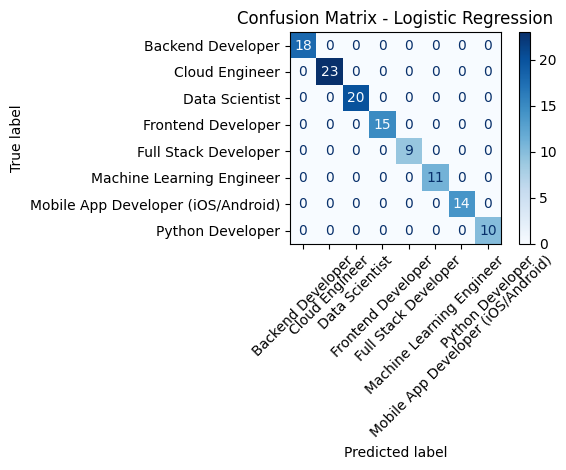

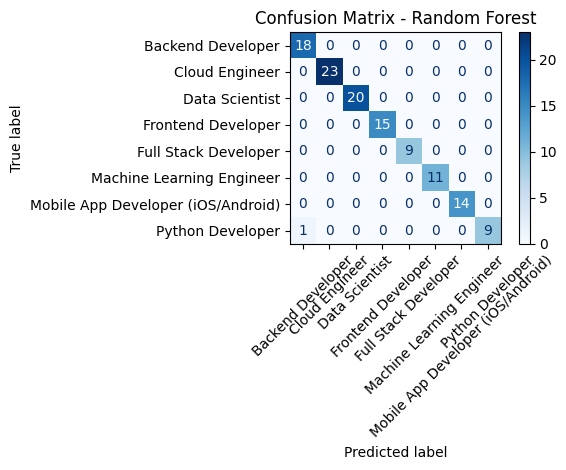

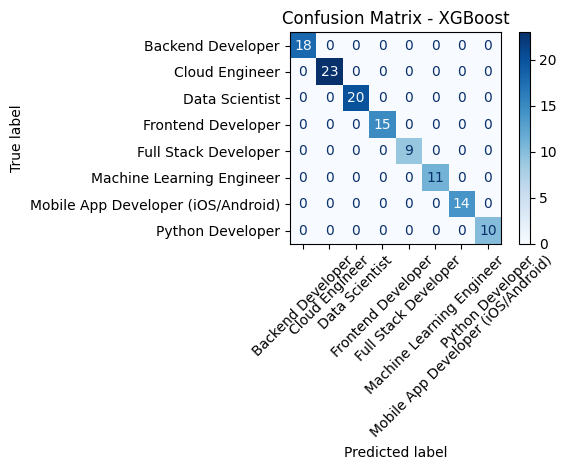

In [7]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\ML IA3 PROJECT\resume_dataset.csv")
X = df['Resume']
y_raw = df['Category']

# Load label encoder and transform labels
label_encoder = joblib.load(r"D:\ML IA3 PROJECT\saved_models\label_encoder.joblib")
y = label_encoder.transform(y_raw)

# Load the same vectorizer used during training
vectorizer = joblib.load(r"D:\ML IA3 PROJECT\saved_models\vectorizer.joblib")
X_tfidf = vectorizer.transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Load trained models
logreg_model = joblib.load(r"D:\ML IA3 PROJECT\saved_models\Logistic_Regression_Tuned.joblib")
rf_model = joblib.load(r"D:\ML IA3 PROJECT\saved_models\Random_Forest_Tuned.joblib")
xgb_model = joblib.load(r"D:\ML IA3 PROJECT\saved_models\XGBoost_Tuned.joblib")

# Show confusion matrix
def show_confusion_matrix(model, model_name):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.inverse_transform(model.classes_))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Display confusion matrices
show_confusion_matrix(logreg_model, "Logistic Regression")
show_confusion_matrix(rf_model, "Random Forest")
show_confusion_matrix(xgb_model, "XGBoost")
